In [1]:
from langgraph.graph import StateGraph, END
from langchain_core.runnables import RunnableLambda

from Agents.doc_parser import parse_documents_node
from Agents.checklist import run_checklist
from Agents.validation import validate_data
from Agents.union_job_classifier import union_job_check
from Agents.pc_llm_mapping import pc_llm_mapping
from Agents.phi_agreement_checker import phi_agreement_checker
from state import PipelineState


def check_po_exists(state: PipelineState) -> PipelineState:
    parsed = state.get("parsed_data", {})
    for doc in parsed.values():
        doc_type = doc.get("result", {}).get("doc_type", "").upper()
        if doc_type == "PO":
            return {"po_check": "Yes"}
    return {"po_check": "No"}

def build_full_pipeline_graph():
    graph = StateGraph(PipelineState)

    # Nodes
    graph.add_node("Parse Documents", RunnableLambda(parse_documents_node))
    graph.add_node("Checklist", RunnableLambda(run_checklist))
    graph.add_node("Check PO Exists", RunnableLambda(check_po_exists))
    graph.add_node("Validate PO data", RunnableLambda(validate_data))
    graph.add_node("Check if Union Job", RunnableLambda(union_job_check))
    graph.add_node("PHI Agreement Check", RunnableLambda(phi_agreement_checker))
    graph.add_node("LLM PC Classifier", RunnableLambda(pc_llm_mapping))

    # Entry
    graph.set_entry_point("Parse Documents")

    # Routing
    graph.add_edge("Parse Documents", "Checklist")
    graph.add_edge("Parse Documents", "Check PO Exists")
    graph.add_edge("Parse Documents", "Check if Union Job")
    graph.add_edge("Parse Documents", "PHI Agreement Check")
    graph.add_edge("Parse Documents", "LLM PC Classifier")

    graph.add_conditional_edges("Check PO Exists", lambda s: s["po_check"], {
        "Yes": "Validate PO data",
        "No": END
    })

    graph.add_edge("Checklist", END)
    graph.add_edge("Validate PO data", END)
    graph.add_edge("Check if Union Job", END)
    graph.add_edge("PHI Agreement Check", END)
    graph.add_edge("LLM PC Classifier", END)

    return graph.compile()


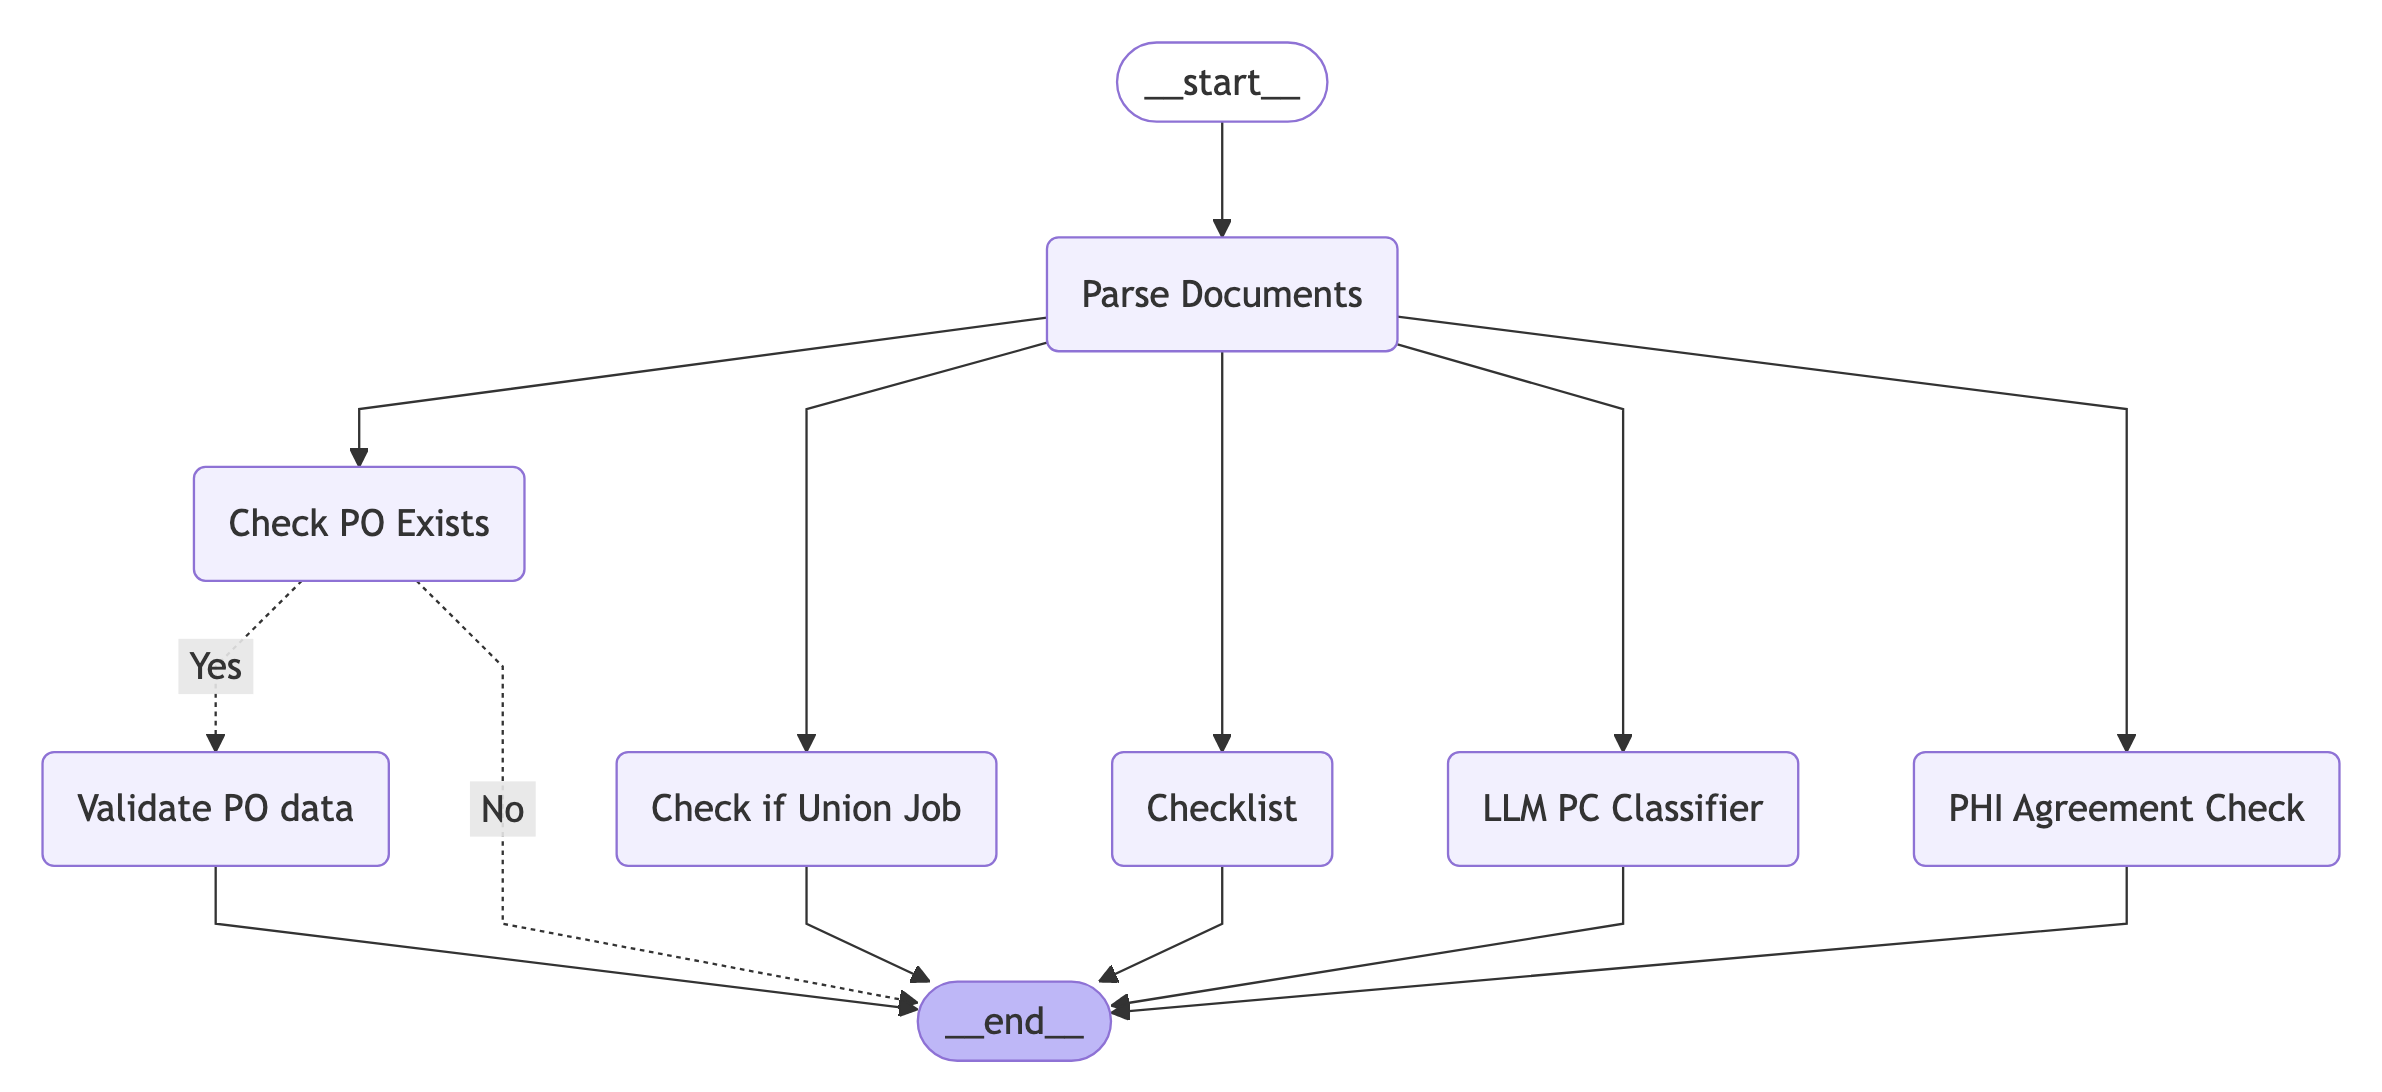

In [2]:
import nest_asyncio
nest_asyncio.apply()
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

app = build_full_pipeline_graph()

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.PYPPETEER
        )
    )
)
